<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/Last_Modified_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lastttttttttttt:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5463385%2F9059806%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240730%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240730T085157Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D68fcce855298615e67908e6a6688858f40869ccade44f39db7ef51273815ed761eb7f7ba0a0b85db6ad8749aa05a64a310d53f1d8e4b1bd2b8eda6e312d26e21338428b9f1f8ec9385ef8eceee97aaf29fd6ee27866d033a002b989d4c029e80aff3c855763a16d811f35f4c9f86d93a83335c86081e8e05881b79017ae35f1cc6de7039204324f029e72fe8a53d059730a1f17253060df9e854f021ccd101b7b85962c51ab3ac7dd8a6af56cecf9e3166a8fd696db641dcbd2c81037de63d5f92d0fa81d882cf47ed5e5ac054de3f4e29124047fb6a3fee22791920c1bfb54a6677e000f1c7ded63ce49f4dc530d1a511f147998fb89614c82eee0ade7cd577'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-29 14:07:11.420264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 14:07:11.420389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 14:07:11.549948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import numpy as np

# Assuming the image dimensions and channels
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Load the file lists
Original = os.listdir('/kaggle/input/lastttttttttttt/images')
Masks = os.listdir('/kaggle/input/lastttttttttttt/masks')

# Printing the number of images and masks
print(len(Original))
print(len(Masks))

# Initialize the arrays with the correct shapes
X = np.zeros((len(Original), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(Masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)
print(X.shape)
print(y.shape)
import cv2
import os
import tensorflow as tf

# Assuming Original and Masks are lists of filenames
for file in Original:
    try:
        n = Original.index(file)
        path1 = os.path.join('/kaggle/input/lastttttttttttt/images', file)
        print(path1)
        img = cv2.imread(path1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        X[n] = img / 255

        file2 = Masks[n]
        path2 = os.path.join('/kaggle/input/lastttttttttttt/masks', file2)
        mask = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = tf.one_hot(mask, 1, dtype=tf.int32)
        y[n] = mask

    except Exception as e:
        print(e)
        print(path1)


3064
3064
(3064, 256, 256, 3)
(3064, 256, 256, 1)
/kaggle/input/lastttttttttttt/images/2664.png
/kaggle/input/lastttttttttttt/images/2539.png
/kaggle/input/lastttttttttttt/images/1231.png
/kaggle/input/lastttttttttttt/images/1017.png
/kaggle/input/lastttttttttttt/images/2437.png
/kaggle/input/lastttttttttttt/images/2015.png
/kaggle/input/lastttttttttttt/images/2300.png
/kaggle/input/lastttttttttttt/images/2673.png
/kaggle/input/lastttttttttttt/images/2823.png
/kaggle/input/lastttttttttttt/images/1522.png
/kaggle/input/lastttttttttttt/images/2064.png
/kaggle/input/lastttttttttttt/images/641.png
/kaggle/input/lastttttttttttt/images/1088.png
/kaggle/input/lastttttttttttt/images/173.png
/kaggle/input/lastttttttttttt/images/2851.png
/kaggle/input/lastttttttttttt/images/2448.png
/kaggle/input/lastttttttttttt/images/1746.png
/kaggle/input/lastttttttttttt/images/1958.png
/kaggle/input/lastttttttttttt/images/1479.png
/kaggle/input/lastttttttttttt/images/815.png
/kaggle/input/lastttttttttttt/ima

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 8,260,977 (31.51 MB)

 Trainable params: 8,258,033 (31.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-29 14:13:10.401112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.41604, expected 2.96419
2024-07-29 14:13:10.401512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 2.39036, expected 1.63582
2024-07-29 14:13:10.401553: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131073: 3.72286, expected 2.96832
2024-07-29 14:13:10.401565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131074: 2.60526, expected 1.85073
2024-07-29 14:13:10.401576: E external/local_xla/xla/service/gpu/buff

  1/153 ━━━━━━━━━━━━━━━━━━━━ 2:22:58 56s/step - accuracy: 0.3492 - loss: 0.8161

I0000 00:00:1722262418.750084     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722262418.825747     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722262418.826852     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722262418.827881     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722262418.828895     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722262418.830553     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/153 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4362 - loss: 0.7654

2024-07-29 14:14:11.476185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.26007, expected 2.3641
2024-07-29 14:14:11.476251: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.67063, expected 3.77466
2024-07-29 14:14:11.476260: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.25337, expected 4.3574
2024-07-29 14:14:11.476268: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.65494, expected 4.75897
2024-07-29 14:14:11.476276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.11017, expected 5.2142
2024-07-29 14:14:11.476284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.20258, expected 5.30661
2024-07-29 14:14:11.476291: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.76833, expected 4.87236
2024-07-29 14:14:11.476299: E external/local_xla/xla/servi

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4417 - loss: 0.7617
Epoch 1: val_accuracy improved from -inf to 0.01816, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 119s 415ms/step - accuracy: 0.4421 - loss: 0.7614 - val_accuracy: 0.0182 - val_loss: 0.9983 - learning_rate: 1.0000e-05
Epoch 2/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.6651 - loss: 0.6593

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-29 14:14:42.497655: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196608: 3.34663, expected 2.36218
2024-07-29 14:14:42.497720: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196609: 5.38306, expected 4.39862
2024-07-29 14:14:42.497734: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196610: 5.72677, expected 4.74232
2024-07-29 14:14:42.497748: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196611: 6.54726, expected 5.56281
2024-07-29 14:14:42.497773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196612: 6.492


Epoch 2: val_accuracy did not improve from 0.01816
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6651 - loss: 0.6593 - val_accuracy: 0.0155 - val_loss: 0.9912 - learning_rate: 1.0000e-05
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6974 - loss: 0.6414
Epoch 3: val_accuracy improved from 0.01816 to 0.09061, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - accuracy: 0.6976 - loss: 0.6413 - val_accuracy: 0.0906 - val_loss: 0.8946 - learning_rate: 1.0000e-05
Epoch 4/100
  1/153 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.8076 - loss: 0.5888
Epoch 4: val_accuracy improved from 0.09061 to 0.10451, saving model to best_model.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8076 - loss: 0.5888 - val_accuracy: 0.1045 - val_loss: 0.8870 - learning_rate: 1.0000e-05
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8209 - loss: 0.5746
Epoch 5: val_accuracy improved from 0.10451 to 0.66624, saving 

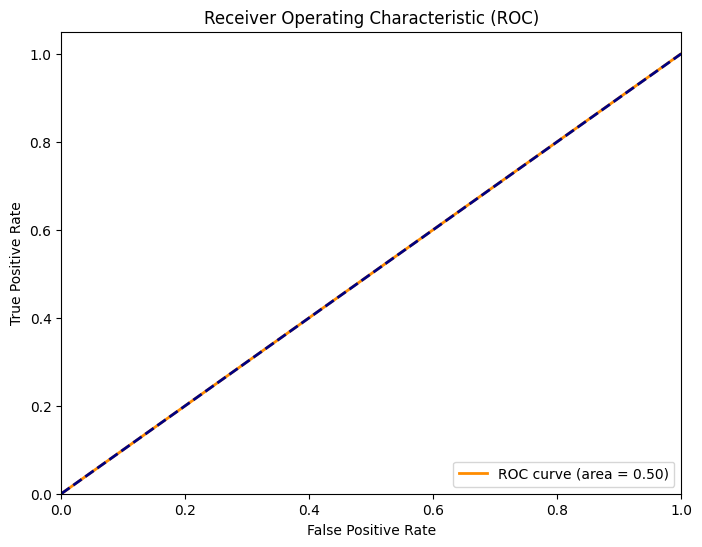

Confusion Matrix:
[[    1415   725741]
 [   64685 39381727]]

Classification Report:
              precision    recall  f1-score   support

  background       0.02      0.00      0.00    727156
       tumor       0.98      1.00      0.99  39446412

    accuracy                           0.98  40173568
   macro avg       0.50      0.50      0.50  40173568
weighted avg       0.96      0.98      0.97  40173568



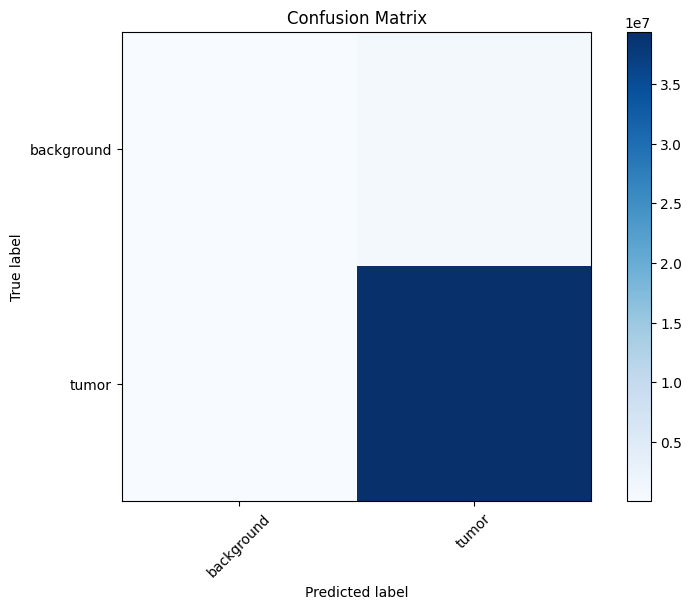

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation, LayerNormalization, Reshape, Permute, Multiply, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import MultiHeadAttention
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Assuming you have X and y defined as your input images and masks
# Replace with your actual data loading and preprocessing
# X and y should be numpy arrays with shape (num_samples, height, width, channels)
# Example:
# X = np.load('images.npy')
# y = np.load('masks.npy')

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define callbacks for learning rate scheduling, early stopping, and model checkpointing
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define data generators
batch_size = 16
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = Permute([2, 1])(x)
    attention_out = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Add()([attention_out, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Conv1D(filters=inputs.shape[-1], kernel_size=1)(y)
    return Add()([x, y])

def additive_attention_block(inputs, filters):
    g1 = Conv2D(filters, kernel_size=1)(inputs)
    g1 = BatchNormalization()(g1)
    g1 = Activation('relu')(g1)

    g2 = Conv2D(filters, kernel_size=1)(inputs)
    g2 = BatchNormalization()(g2)
    g2 = Activation('relu')(g2)

    attention = Add()([g1, g2])
    attention = Activation('sigmoid')(attention)

    output = Multiply()([inputs, attention])
    return output

def trans_unet_attention(input_size=(256, 256, 3), head_size=256, num_heads=4, ff_dim=1024, num_transformer_blocks=4):
    inputs = Input(input_size)

    # U-Net Contracting Path
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, 256)

    # Transformer Encoder-Decoder Blocks
    x = Reshape((-1, c5.shape[1]*c5.shape[2]))(c5)
    mask = tf.linalg.band_part(tf.ones((x.shape[1], x.shape[1])), -1, 0)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
    x = Reshape((c5.shape[1], c5.shape[2], -1))(x)

    # Additive Attention Block
    attention = additive_attention_block(c5, 256)

    # U-Net Expanding Path with Attention
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    u4 = concatenate([u4, c4])
    u4 = conv_block(u4, 128)

    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u4)
    u3 = concatenate([u3, c3])
    u3 = conv_block(u3, 64)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u3)
    u2 = concatenate([u2, c2])
    u2 = conv_block(u2, 32)

    u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u2)
    u1 = concatenate([u1, c1])
    u1 = conv_block(u1, 16)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Compile the model
model = trans_unet_attention()
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=100,  # Increase epochs for further training
                    validation_data=test_generator,
                    validation_steps=len(X_test) // batch_size,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Evaluate the model
model = tf.keras.models.load_model('best_model.keras')  # Load the best model
y_pred = model.predict(test_generator, steps=len(X_test) // batch_size + 1)
y_pred = (y_pred > 0.5).astype(np.uint8)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print and plot confusion matrix and classification report
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test.ravel(), y_pred.ravel(), target_names=['background', 'tumor']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['background', 'tumor'], rotation=45)
plt.yticks(tick_marks, ['background', 'tumor'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

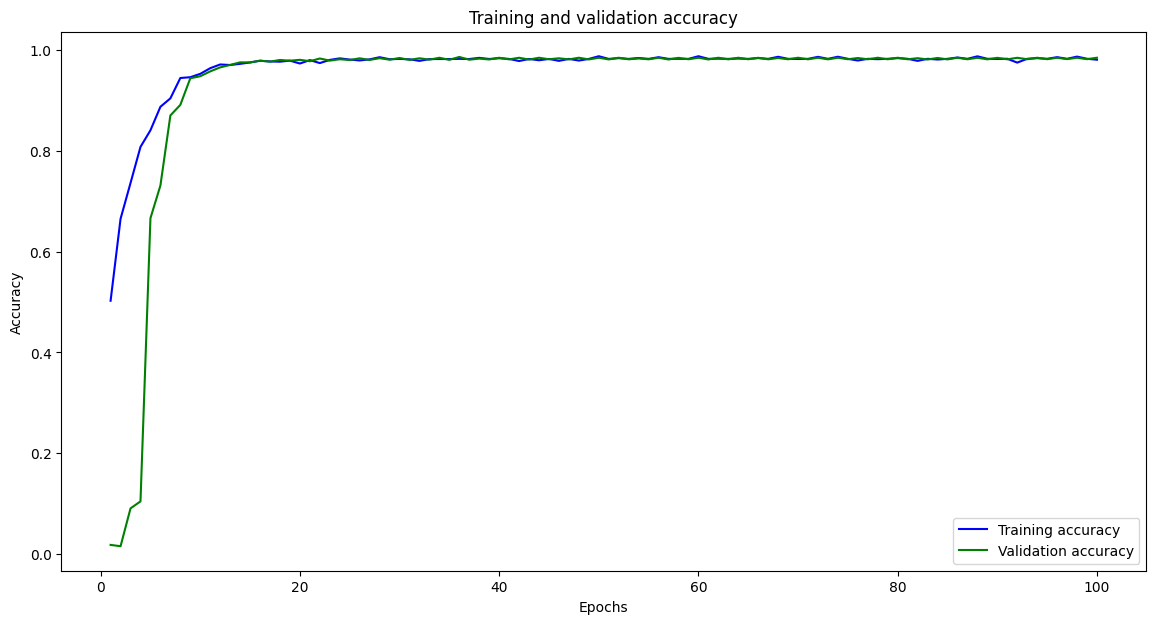

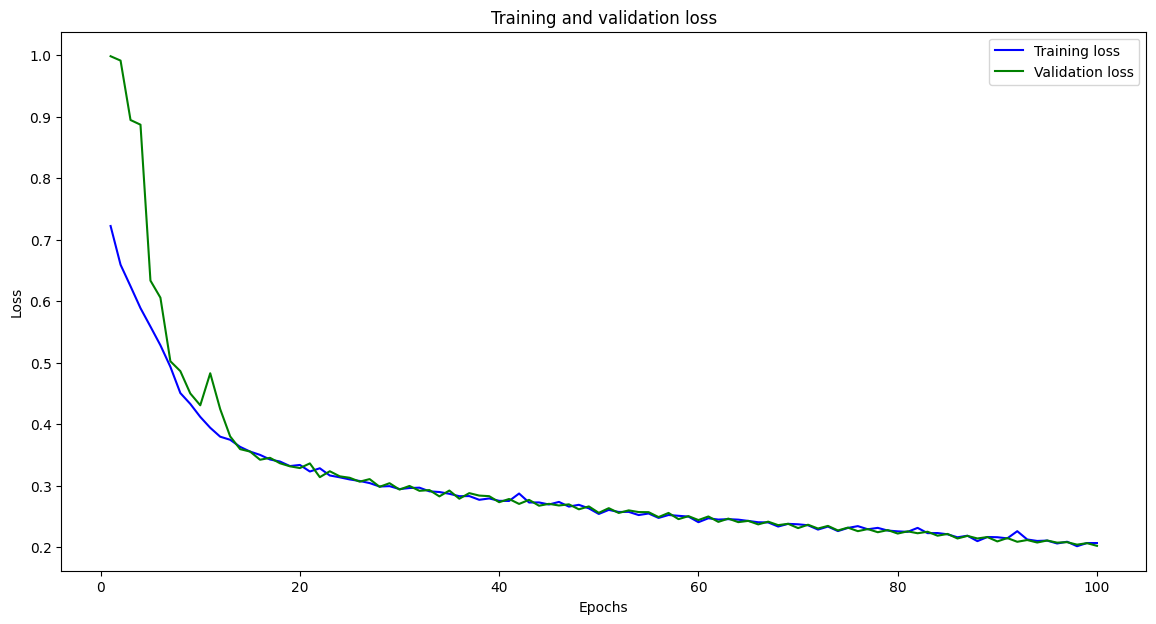

Final Training Accuracy: 0.9806
Final Validation Accuracy: 0.9845
Final Training Loss: 0.2069
Final Validation Loss: 0.2023


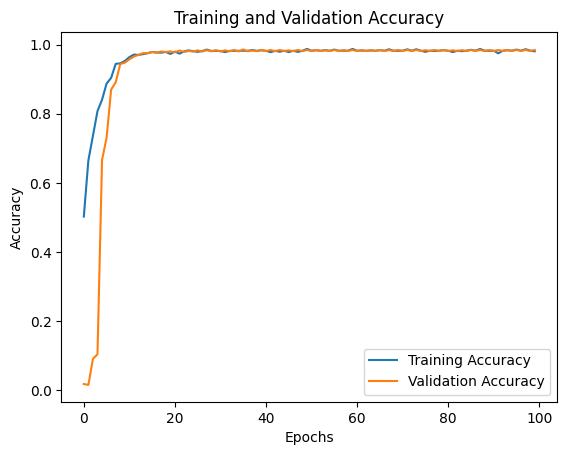

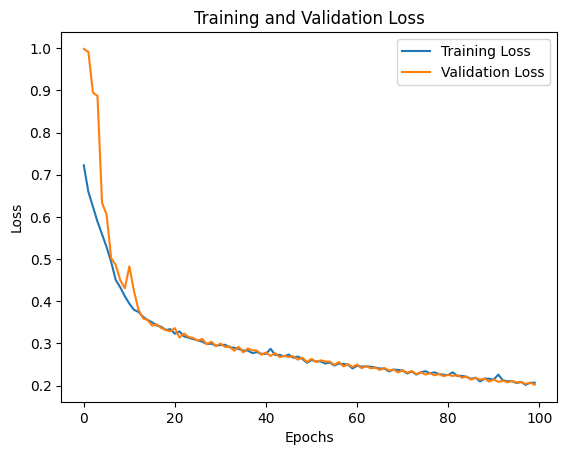

2024-07-29 14:49:49.195847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.96116, expected 2.28267
2024-07-29 14:49:49.195910: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13388, expected 3.45539
2024-07-29 14:49:49.195920: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.32371, expected 3.64522
2024-07-29 14:49:49.195928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.43312, expected 4.75463
2024-07-29 14:49:49.195936: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.46228, expected 4.78378
2024-07-29 14:49:49.195943: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.69444, expected 5.01594
2024-07-29 14:49:49.195951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.74803, expected 4.06954
2024-07-29 14:49:49.195959: E external/local_xla/xla/se

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

W0000 00:00:1722264597.614408     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722264597.616014     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722264597.617470     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722264597.618954     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step
Confusion Matrix:
[[      24   727132]
 [   63728 39382684]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    727156
           1       0.98      1.00      0.99  39446412

    accuracy                           0.98  40173568
   macro avg       0.49      0.50      0.50  40173568
weighted avg       0.96      0.98      0.97  40173568



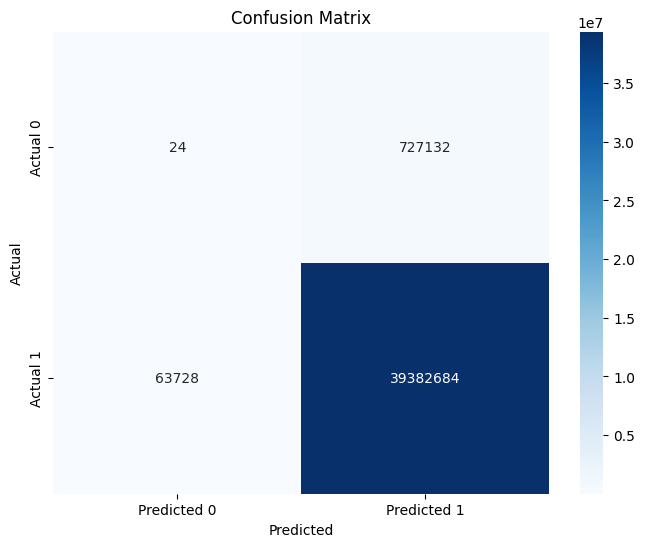

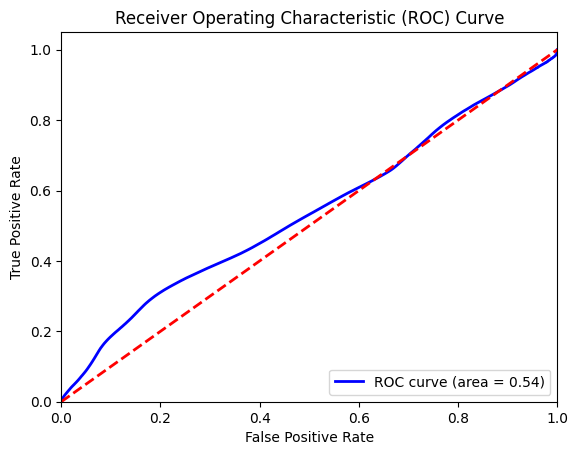

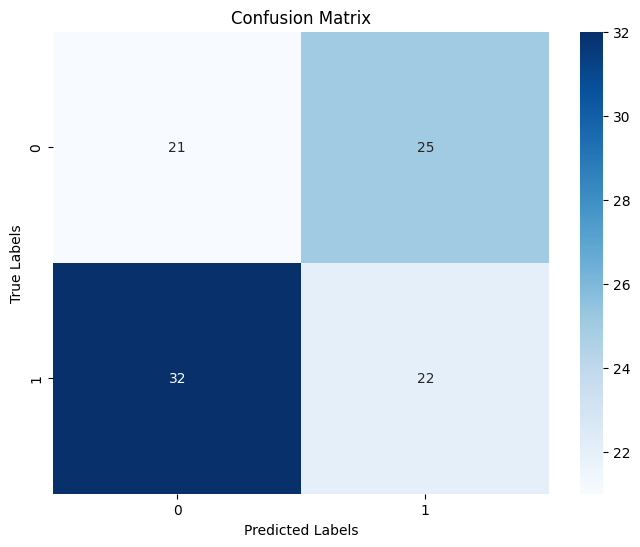

In [ ]:
# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 7))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final accuracy and loss
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to binary
y_pred_binary = (y_pred > 0.5).astype(np.int32)
y_test_binary = (y_test > 0.5).astype(np.int32)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary.flatten(), y_pred_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_binary.flatten(), y_pred_binary.flatten()))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test_binary.flatten(), y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Sample true labels and predicted labels (values between 0 and 1)
y_true = np.random.randint(2, size=100)
y_pred = np.random.rand(100)

# Binarize predictions based on a threshold of 0.5
y_pred_bin = (y_pred >= 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_bin)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to compute confusion matrix for segmentation
def compute_confusion_matrix(y_true, y_pred, num_classes=2):
    # Flatten the arrays
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return cm, cm_normalized

# Make predictions on the test set
y_pred = model.predict(X_test)

# Binarize predictions based on threshold 0.5
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# Compute confusion matrix
cm, cm_normalized = compute_confusion_matrix(y_test, y_pred_bin)

print("Confusion Matrix:")
print(cm)
print("Normalized Confusion Matrix:")
print(cm_normalized)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Confusion Matrix:
[[      24   727132]
 [   63728 39382684]]
Normalized Confusion Matrix:
[[3.30052974e-05 9.99966995e-01]
 [1.61555885e-03 9.98384441e-01]]


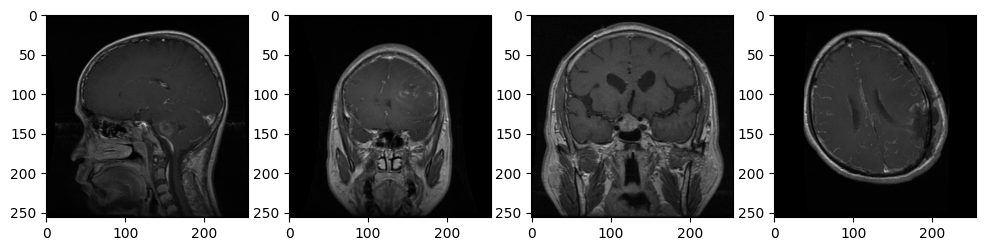

In [ ]:
import matplotlib.pyplot as plt
i = np.random.randint(1, 100)
plt.figure(figsize = (12,15))
plt.subplot(141)
plt.imshow(X[i])

plt.subplot(142)
plt.imshow(X[i+1])

plt.subplot(143)
plt.imshow(X[i+2])

plt.subplot(144)
plt.imshow(X[i+3])

In [ ]:
def predict_image(img_path, mask_path, model):
    H = 256
    W = 256
    num_classes = 1

    img = cv2.imread(img_path)
    img = img[:256, :256, :]
    img = img / 255.0
    img = img.astype(np.float32)


    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    #pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

2024-07-29 14:56:54.599082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.46471, expected 2.7814
2024-07-29 14:56:54.599150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.03943, expected 4.35612
2024-07-29 14:56:54.599164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.38665, expected 4.70334
2024-07-29 14:56:54.599175: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.56278, expected 4.87948
2024-07-29 14:56:54.599188: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.43827, expected 4.75496
2024-07-29 14:56:54.599196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 5.45952, expected 4.77621
2024-07-29 14:56:54.599204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.01216, expected 4.32885
2024-07-29 14:56:54.599218: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


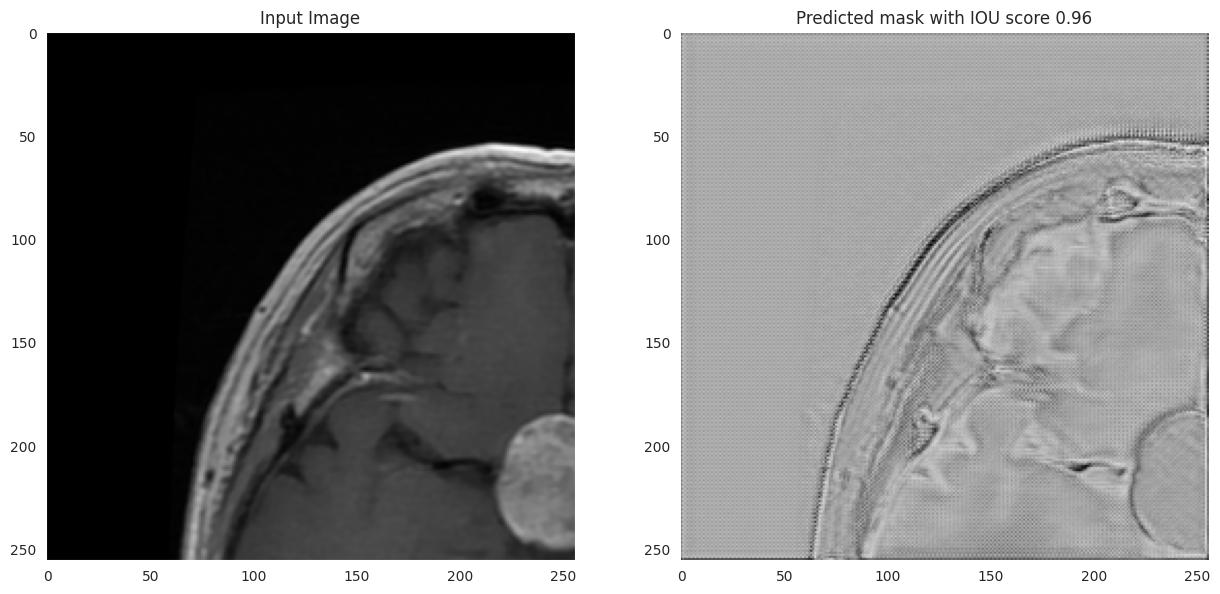

In [ ]:
sns.set_style('dark')
img_path = '/kaggle/input/lastttttttttttt/images/1019.png'
mask_path = '/kaggle/input/lastttttttttttt/masks/1019.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("Predicted mask with IOU score %.2f"%(iou))
ax2.imshow(pred_mask, cmap='gray')

plt.show()